In [108]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [109]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd

In [110]:
import trackml
from trackml.dataset import load_event, load_dataset

In [111]:
def curvature(h, ptmin, region_origin_radius,hardPtCut) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['x1']
    y1 = h['y1']
    x2 = h['x2']
    y2 = h['y2']
    x3 = h['x3']
    y3 = h['y3']
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*165 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
    
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [112]:
def alignRZ(h, ptmin) :
    ri = h['r1']
    zi = h['z1']
    rm = h['r2']
    zm = h['z2']
    ro = h['r3']
    zo = h['z3']
    radius_diff = abs(rm - ro)
    distance_13_squared = radius_diff*radius_diff + (zm - zo)*(zm - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = abs(zm * (ri - ro) + zi * (ro - rm) + zo * (rm - ri)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [113]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

1000 120939 120939
8708 7106 5995 5146


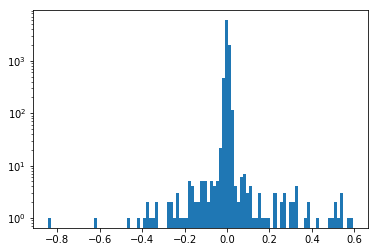

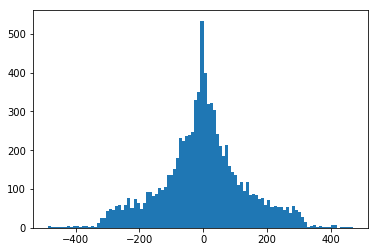

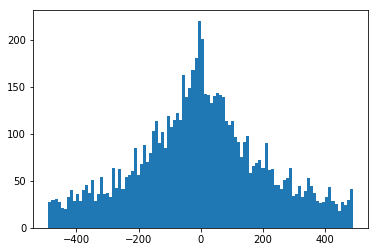

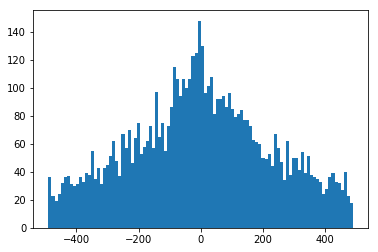

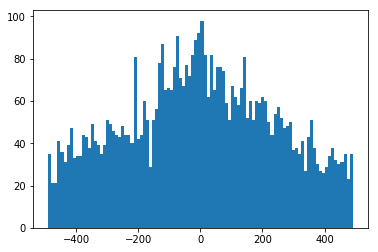

t123 8917 6784
thcut 6784
8708 6155


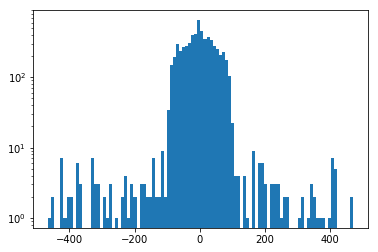

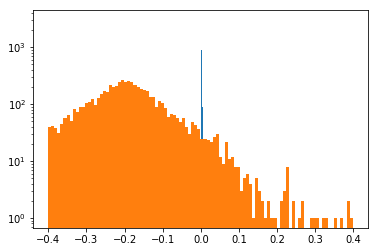

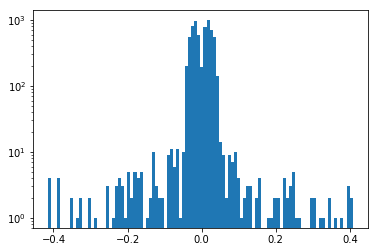

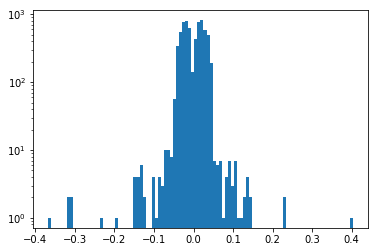

1001 93680 93680
6541 5277 4340 3612


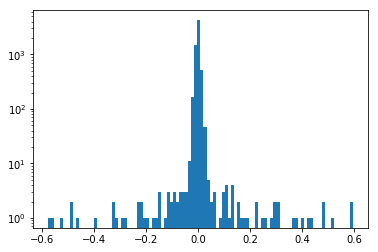

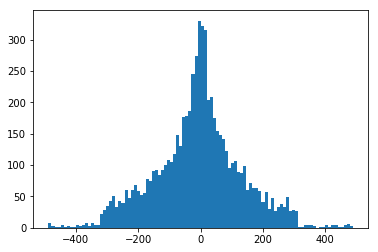

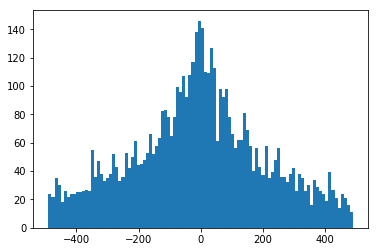

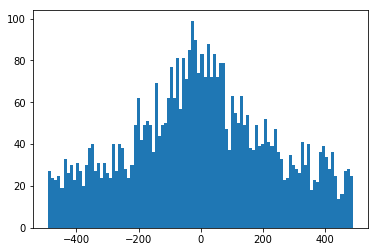

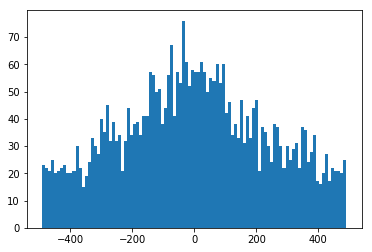

t123 6621 4977
thcut 4977
6541 4398


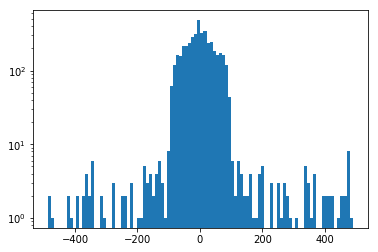

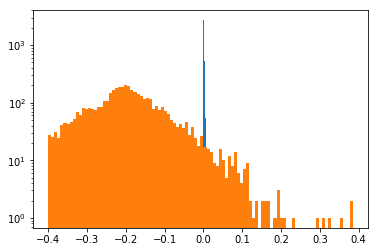

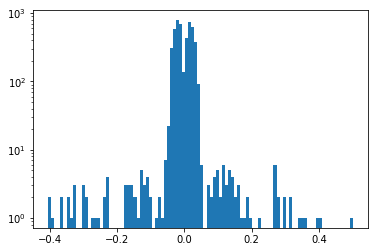

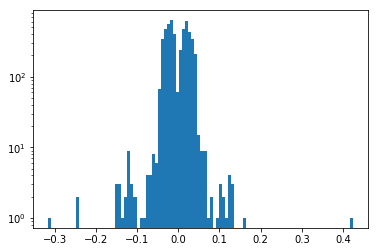

done 3


In [116]:
file = '/Users/innocent/data/trackML_minitrain.zip'
#file = '/Users/innocent/data/train_100_events'
maxEv = 2
evn=0
for event_id, hits, cells, particles, truth in load_dataset(file):
    evn+=1
    if (evn>maxEv) : break
    print event_id, len(hits), len(truth)
    #hits = pd.concat([hits,truth],axis=1)
    hits = pd.merge(hits,truth,on='hit_id')
    hits['phi'] = np.arctan2(hits['y'],hits['x'])
    hits['r'] = np.sqrt(hits['y']*hits['y']+hits['x']*hits['x'])
    hits['tr'] = np.sqrt(hits['ty']*hits['ty']+hits['tx']*hits['tx'])
    hits['tpt'] = np.sqrt(hits['tpx']*hits['tpx']+hits['tpy']*hits['tpy'])
    hits['up0'] =0
    hits['up1'] =0
   
    hits.sort_values(by=['particle_id'],inplace=True)
    # print hits
    hl1 = hits.query('volume_id ==8 & layer_id==2 & particle_id!=0')
    hl2 = hits.query('volume_id ==8 & layer_id==4 & particle_id!=0')
    hl3 = hits.query('volume_id ==8 & layer_id==6 & particle_id!=0')
    hl4 = hits.query('volume_id ==8 & layer_id==8 & particle_id!=0')
    print len(hl1), len(hl2), len(hl3), len(hl4)
    plt.hist(hl1['z']-hl1['tz'],log=True, bins=100)
    plt.show()
    plt.hist(hl1['z'],log=False, bins=100)
    plt.show()
    plt.hist(hl2['z'],log=False, bins=100)
    plt.show()
    plt.hist(hl3['z'],log=False, bins=100)
    plt.show()
    plt.hist(hl4['z'],log=False, bins=100)
    plt.show()

    z1 = pd.DataFrame({ 'z1' : hl1['z'],
                       'x1' : hl1['x'],
                       'y1' : hl1['y'],
                       'r1' : hl1['r'],'phi1' : hl1['phi'],
                       'tpt' : hl1['tpt'],
                       'particle_id' : hl1['particle_id']
                       })
    z2 = pd.DataFrame({ 'z2' : hl2['z'],
                       'x2' : hl2['x'],
                       'y2' : hl2['y'],
                       'r2' : hl2['r'],'phi2' : hl2['phi'],
                       'particle_id' : hl2['particle_id']
                       })
    z3 = pd.DataFrame({ 'z3' : hl3['z'],
                       'x3' : hl3['x'],
                       'y3' : hl3['y'],
                       'r3' : hl3['r'],'phi3' : hl3['phi'],
                       'particle_id' : hl3['particle_id']
                       })
    p4 = pd.DataFrame({'particle_id' :hl4['particle_id']})
    t123 = pd.merge(z1,z2,on='particle_id')
    t123 = pd.merge(t123,z3,on='particle_id')
    print 't123',len(t123),len(t123[t123['tpt']>0.3])
    # print t123
    t123 = t123[t123['tpt']>0.3]
    thcut = alignRZ(t123,0.6)
    curv = curvature(t123,0.6,0.2,0.2)
    print 'thcut',len(thcut)
    # print thcut
    # print curv
    zl4 = pd.merge(z1,p4,on='particle_id')
    print len(z1),len(zl4)
    # plt.hist(z1['z'],log=True, bins=100)
    plt.hist(zl4['z1'],log=True, bins=100)
    plt.show()
    plt.hist(thcut[thcut<0.1],log=True, bins=100)
    plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
    plt.show()
    d1 = t123['phi1']-t123['phi2']
    plt.hist(d1[abs(d1)<0.5], bins=100,log=True)
    plt.show()
    d2 = t123['phi2']-t123['phi3']
    plt.hist(d2[abs(d2)<0.5], bins=100,log=True)
    plt.show()
    
    
print 'done', evn